# Happy Portfolio Analysis

In [37]:
# Import relevant libraries

import pickle
import pandas as pd
import plotly.express as px
import numpy as np


In [2]:
# Read in etf data from pkl file

pkl_file = open('etf_df.pkl', 'rb')
dataframe2 = pickle.load(pkl_file)
pkl_file.close()

# load etf data back into Dataframe
all_etf_df = pd.DataFrame(dataframe2)

# Convert month end prices to monthly percentage change and drop na values

all_etf_df = all_etf_df.pct_change().dropna()


In [3]:
# Review dataframe

all_etf_df.head()

,iShares MSCI Finland Capped,iShares MSCI Denmark Capped,iShares MSCI Norway Capped,iShares MSCI Netherlands,iShares MSCI Switzerland Capped,iShares MSCI Sweden Capped,iShares MSCI New Zealand Capped,iShares MSCI Canada,iShares MSCI Austria Capped,iShares MSCI Australia,iShares MSCI Israel Capped,iShares MSCI United Kingdom,ishares S&P 500,iShares MSCI Ireland,iShares Currency Hedged MSCI Germany,iShares MSCI Mexico Capped,iShares MSCI World
date,,,,,,,,,,,,,,,,,
2015-02-01,0.051509,0.078402,0.037898,0.066694,0.049449,0.070284,0.062257,0.059758,0.122674,0.080292,0.032922,0.058758,0.056431,0.126511,0.070004,0.070400,0.066838
2015-03-01,-0.021739,0.028807,-0.058921,-0.012114,-0.003301,-0.035714,-0.021734,-0.029979,-0.031921,-0.034628,0.060809,-0.057068,-0.020621,-0.024607,0.043129,-0.037369,-0.014355
2015-04-01,-0.009481,0.050476,0.128748,0.032832,0.040048,0.016129,0.012232,0.071376,0.069753,0.020122,0.021150,0.066630,0.009684,0.053677,-0.051156,0.011387,0.017830
2015-05-01,0.010470,0.007616,-0.039453,0.017618,0.024899,-0.001764,-0.059926,-0.046016,-0.005928,-0.033448,-0.002129,0.006247,0.013027,0.007641,0.005908,-0.001876,0.004279
2015-06-01,-0.037892,-0.031852,-0.051647,-0.033120,-0.074859,-0.064488,-0.090241,-0.039957,-0.053667,-0.066992,-0.002328,-0.055872,-0.025201,-0.012133,-0.042217,-0.023928,-0.038615


In [40]:
# Read in country data from pkl file

pkl_file = open('wh_2015_2019.pkl', 'rb')
dataframe3 = pickle.load(pkl_file)
pkl_file.close()

# load etf data back into Dataframe
wh_2015_2019_df = pd.DataFrame(dataframe3)

# Drop Year Column
wh_2015_2019_df = wh_2015_2019_df.drop(columns=['Year'])

In [41]:
# Review Dataframe 

wh_2015_2019_df

Country,Switzerland,Denmark,Norway,Canada,Finland,Netherlands,Sweden,New Zealand,Australia,Israel,Austria,Mexico,United States,Ireland,United Kingdom,Germany
Happiness Score 2015,7.587,7.527,7.522,7.427,7.406,7.378,7.364,7.286,7.284,7.278,7.200,7.187,7.119,NaN,NaN,NaN
Happiness Score 2016,7.509,7.526,7.498,7.404,7.413,7.339,7.291,7.334,7.313,7.267,7.119,NaN,7.104,NaN,NaN,NaN
Happiness Score 2017,7.494,7.522,7.537,7.316,7.469,7.377,7.284,7.314,7.284,7.213,7.006,NaN,6.993,6.977,NaN,NaN
Happiness Score 2018,7.487,7.555,7.594,7.328,7.632,7.441,7.314,7.324,7.272,NaN,7.139,NaN,NaN,6.977,7.190,6.965
Happiness Score 2019,7.480,7.600,7.554,7.278,7.769,7.488,7.343,7.307,7.228,7.139,7.246,NaN,NaN,NaN,7.054,NaN


In [6]:
# Transpose dataframe to allow mapping to ETFs by Country

wh_2015_2019_df = wh_2015_2019_df.transpose()
wh_2015_2019_df = wh_2015_2019_df.drop(['Year'])
wh_2015_2019_df


,Happiness Score 2015,Happiness Score 2016,Happiness Score 2017,Happiness Score 2018,Happiness Score 2019
Country,,,,,
Switzerland,7.587,7.509,7.494,7.487,7.480
Denmark,7.527,7.526,7.522,7.555,7.600
Norway,7.522,7.498,7.537,7.594,7.554
Canada,7.427,7.404,7.316,7.328,7.278
Finland,7.406,7.413,7.469,7.632,7.769
Netherlands,7.378,7.339,7.377,7.441,7.488
Sweden,7.364,7.291,7.284,7.314,7.343
New Zealand,7.286,7.334,7.314,7.324,7.307
Australia,7.284,7.313,7.284,7.272,7.228


## Portfolio Mapping

In [7]:
# Create Map of ETFs to Countries

etf_country_map = {
    "Finland":"iShares MSCI Finland Capped",
    "Denmark":"iShares MSCI Denmark Capped",
    "Norway":"iShares MSCI Norway Capped",
    "Netherlands":"iShares MSCI Netherlands",
    "Switzerland":"iShares MSCI Switzerland Capped",
    "Sweden":"iShares MSCI Sweden Capped",
    "New Zealand":"iShares MSCI New Zealand Capped",
    "Canada":"iShares MSCI Canada",
    "Austria":"iShares MSCI Austria Capped",
    "Australia":"iShares MSCI Australia",
    "Israel":"iShares MSCI Israel Capped",
    "United Kingdom":"iShares MSCI United Kingdom",
    "United States":"ishares S&P 500",
    "Ireland":"iShares MSCI Ireland",
    "Germany":"iShares Currency Hedged MSCI Germany",
    "Mexico":"iShares MSCI Mexico Capped",
    "Benchmark":"iShares MSCI World"
}

# Create DataFrame of Countries and Corresponding ETFs

etf_country_map_df = pd.DataFrame.from_dict(etf_country_map, orient='index')
etf_country_map_df.columns = ["ETF"]
etf_country_map_df.index.name = "Country"
etf_country_map_df

,ETF
Country,
Finland,iShares MSCI Finland Capped
Denmark,iShares MSCI Denmark Capped
Norway,iShares MSCI Norway Capped
Netherlands,iShares MSCI Netherlands
Switzerland,iShares MSCI Switzerland Capped
Sweden,iShares MSCI Sweden Capped
New Zealand,iShares MSCI New Zealand Capped
Canada,iShares MSCI Canada
Austria,iShares MSCI Austria Capped


In [8]:
# Combine Dataframes to show Happiness Score by ETF (for Portfolio Weights)

country_etf_combined = pd.merge(etf_country_map_df, wh_2015_2019_df,on='Country', how='outer')

country_etf_combined.set_index('ETF', inplace=True, drop=True)
columns = [2015,2016,2017,2018,2019]
country_etf_combined.columns = columns

country_etf_combined


,2015,2016,2017,2018,2019
ETF,,,,,
iShares MSCI Finland Capped,7.406,7.413,7.469,7.632,7.769
iShares MSCI Denmark Capped,7.527,7.526,7.522,7.555,7.600
iShares MSCI Norway Capped,7.522,7.498,7.537,7.594,7.554
iShares MSCI Netherlands,7.378,7.339,7.377,7.441,7.488
iShares MSCI Switzerland Capped,7.587,7.509,7.494,7.487,7.480
iShares MSCI Sweden Capped,7.364,7.291,7.284,7.314,7.343
iShares MSCI New Zealand Capped,7.286,7.334,7.314,7.324,7.307
iShares MSCI Canada,7.427,7.404,7.316,7.328,7.278
iShares MSCI Austria Capped,7.200,7.119,7.006,7.139,7.246


# Portfolio Weightings

In [9]:
# Create new Dataframe to weight the ETFs by Happiness Score
country_etf_weighted = country_etf_combined


# Recalculate Dataframe to Weight each Score by Year

country_etf_weighted["2015 Weights"] = (country_etf_weighted[2015]/country_etf_weighted[2015].sum()) * 100
country_etf_weighted["2016 Weights"] = (country_etf_weighted[2016]/country_etf_weighted[2016].sum()) * 100
country_etf_weighted["2017 Weights"] = (country_etf_weighted[2017]/country_etf_weighted[2017].sum()) * 100
country_etf_weighted["2018 Weights"] = (country_etf_weighted[2018]/country_etf_weighted[2018].sum()) * 100
country_etf_weighted["2019 Weights"] = (country_etf_weighted[2019]/country_etf_weighted[2019].sum()) * 100

# Drop original score columns to leave only the portfolio weights
country_etf_weighted = country_etf_weighted.drop(columns=[2015,2016,2017,2018,2019])

# Rename the columns
columns = [2015,2016,2017,2018,2019]
country_etf_weighted.columns = columns

# Review the weighted DataFrame
country_etf_weighted


,2015,2016,2017,2018,2019
ETF,,,,,
iShares MSCI Finland Capped,7.749699,8.412679,7.879856,8.015291,8.779920
iShares MSCI Denmark Capped,7.876315,8.540917,7.935771,7.934424,8.588929
iShares MSCI Norway Capped,7.871083,8.509141,7.951596,7.975383,8.536944
iShares MSCI Netherlands,7.720400,8.328699,7.782795,7.814699,8.462356
iShares MSCI Switzerland Capped,7.939099,8.521625,7.906231,7.863009,8.453315
iShares MSCI Sweden Capped,7.705750,8.274226,7.684679,7.681321,8.298488
iShares MSCI New Zealand Capped,7.624130,8.323025,7.716330,7.691823,8.257803
iShares MSCI Canada,7.771674,8.402465,7.718439,7.696024,8.225030
iShares MSCI Austria Capped,7.534139,8.079031,7.391387,7.497532,8.188866


In [10]:
# Check all columns total 100
country_etf_weighted.sum()

2015    100.0
2016    100.0
2017    100.0
2018    100.0
2019    100.0
dtype: float64

## Portfolio Return

In [32]:

# Set starting values for 2015 based on weight
portfolio_start_2015 = country_etf_weighted.iloc[:,0]

# Check total = 100
display(portfolio_start_2015.sum())

# Create new dataframe for 2015 return calc using the 2015 start values
portfolio_return_2015 = pd.DataFrame(portfolio_start_2015)
portfolio_return_2015 = portfolio_return_2015.transpose()

# Rename weighted value index to start date 01-01-2015
portfolio_return_2015 = portfolio_return_2015.reset_index(drop=True)
portfolio_return_2015 = portfolio_return_2015.rename(index={0:'2015-01-01'})

# Append the all_etf_df monthly returns
portfolio_return_2015 = portfolio_return_2015.append(all_etf_df.loc['2015-02-01':'2015-12-31']).sort_index()

# Calculate cumulative return and drop na row
portfolio_return_2015 = (1 + portfolio_return_2015.shift(1)).cumprod().dropna(how='all')

# Drop ETFs not included in portfolio for 2015
portfolio_return_2015 = portfolio_return_2015.dropna(axis=1)

# Review the dataframe
portfolio_return_2015

100.0

,iShares MSCI Finland Capped,iShares MSCI Denmark Capped,iShares MSCI Norway Capped,iShares MSCI Netherlands,iShares MSCI Switzerland Capped,iShares MSCI Sweden Capped,iShares MSCI New Zealand Capped,iShares MSCI Canada,iShares MSCI Austria Capped,iShares MSCI Australia,iShares MSCI Israel Capped,ishares S&P 500,iShares MSCI Mexico Capped
2015-02-01,8.749699,8.876315,8.871083,8.720400,8.939099,8.705750,8.624130,8.771674,8.534139,8.622037,8.615759,8.449380,8.520536
2015-03-01,9.200385,9.572239,9.207282,9.302002,9.381127,9.317621,9.161041,9.295851,9.581056,9.314318,8.899405,8.926184,9.120381
2015-04-01,9.000376,9.847982,8.664778,9.189317,9.350157,8.984849,8.961937,9.017174,9.275215,8.991778,9.440573,8.742118,8.779560
2015-05-01,8.915039,10.345071,9.780349,9.491023,9.724614,9.129766,9.071556,9.660784,9.922186,9.172715,9.640245,8.826780,8.879534
2015-06-01,9.008377,10.423855,9.394484,9.658233,9.966743,9.113664,8.527934,9.216229,9.863371,8.865909,9.619718,8.941769,8.862872
2015-07-01,8.667029,10.091837,8.909287,9.338352,9.220645,8.525946,7.758361,8.847978,9.334031,8.271964,9.597325,8.716424,8.650805
2015-08-01,8.963041,10.585174,8.672419,9.632788,9.600733,8.598404,7.798630,8.476409,9.628109,8.228696,10.302708,8.907230,8.534169
2015-09-01,8.397684,10.125601,7.973277,8.894880,8.958807,8.139501,7.208028,8.051760,9.145821,7.335812,9.380858,8.360084,8.005517
2015-10-01,8.096339,9.949276,7.442235,8.505934,8.612505,7.790626,7.154337,7.630427,8.810572,7.048673,8.962853,8.106098,7.810112
2015-11-01,8.749699,9.938021,7.858664,9.087536,8.944730,8.091195,8.127488,7.895833,9.398728,7.442014,9.401385,8.793084,8.288777


In [33]:
# Create a new benchmark dataframe, rebase to 100 for comparible data to portfolio

benchmark = pd.DataFrame(index=["Benchmark"], data=[100], columns=["2015-01-01"])

# Append benchmark data from all_etf_df and combine into a single columns

benchmark = benchmark.append(all_etf_df["iShares MSCI World"])
benchmark = benchmark.transpose().sum(axis=1)

# Slice by date 
benchmark = benchmark.loc["2015-01-01":"2015-12-31"]

# Calculate cumulative return and drop na (first value)
benchmark = (1 + benchmark.shift(1)).cumprod().dropna()
benchmark

2015-02-01    101.000000
2015-03-01    107.750680
2015-04-01    106.203950
2015-05-01    108.097610
2015-06-01    108.560183
2015-07-01    104.368112
2015-08-01    107.114641
2015-09-01    100.074853
2015-10-01     96.518821
2015-11-01    103.240590
2015-12-01    103.529698
dtype: float64

In [34]:
# Combine return for portfolio

portfolio_return_2015 = portfolio_return_2015.sum(axis=1)
portfolio_return_2015

2015-02-01    113.000000
2015-03-01    120.278893
2015-04-01    118.245814
2015-05-01    122.559663
2015-06-01    121.463158
2015-07-01    115.929985
2015-08-01    117.928512
2015-09-01    109.977630
2015-10-01    105.919986
2015-11-01    112.017153
2015-12-01    111.694424
dtype: float64

In [35]:
# Create plot dataframe by combining benchmark and portfolio return dfs

plot_df = pd.concat([portfolio_return_2015, benchmark.loc["2015-01-01":"2015-12-31"]], axis=1)

# Rename columns
columns = ["Happy Portfolio","Benchmark"]
plot_df.columns = columns

# Add back in the start value of 100 for the plot
new_row = pd.DataFrame({"Happy Portfolio":100, "Benchmark":100}, index=['2015-01-01'])
plot_df = pd.concat([plot_df, new_row]).sort_index()

# Review
plot_df


,Happy Portfolio,Benchmark
2015-01-01,100.000000,100.000000
2015-02-01,113.000000,101.000000
2015-03-01,120.278893,107.750680
2015-04-01,118.245814,106.203950
2015-05-01,122.559663,108.097610
2015-06-01,121.463158,108.560183
2015-07-01,115.929985,104.368112
2015-08-01,117.928512,107.114641
2015-09-01,109.977630,100.074853
2015-10-01,105.919986,96.518821


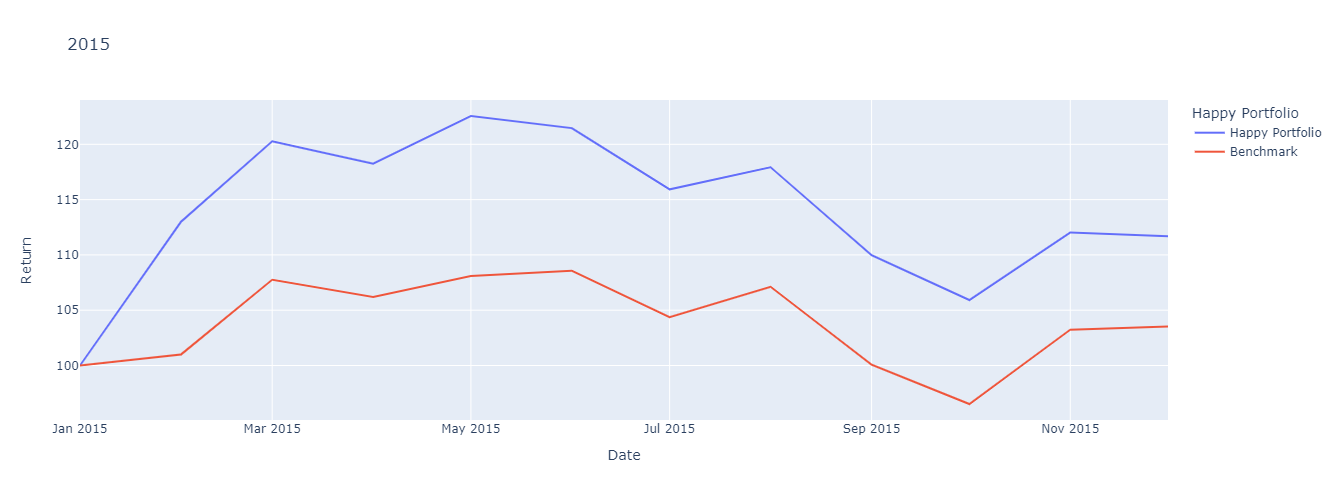

In [36]:
# Plot 2015

fig = px.line(
    plot_df,
    title="2015",
    height=500,
    width=1000,
    labels={
        "value":"Return",
        "index":"Date",
        "variable":"Happy Portfolio"
    }
)
fig.show()

## Review calcs needed from here

In [16]:
# Annual Return
all_etf_df_return_2015 = all_etf_df.loc['2015-01-01':'2015-12-31'].mean() * 12
all_etf_df_return_2015 = pd.DataFrame(all_etf_df_return_2015, columns=[2015])

all_etf_df_return_2016 = all_etf_df.loc['2016-01-01':'2016-12-31'].mean() * 12
all_etf_df_return_2016 = pd.DataFrame(all_etf_df_return_2016, columns=[2016])

all_etf_df_return_2017 = all_etf_df.loc['2017-01-01':'2017-12-31'].mean() * 12
all_etf_df_return_2017 = pd.DataFrame(all_etf_df_return_2017, columns=[2017])

all_etf_df_return_2018 = all_etf_df.loc['2018-01-01':'2018-12-31'].mean() * 12
all_etf_df_return_2018 = pd.DataFrame(all_etf_df_return_2018, columns=[2018])

all_etf_df_return_2019 = all_etf_df.loc['2019-01-01':'2019-12-31'].mean() * 12
all_etf_df_return_2019 = pd.DataFrame(all_etf_df_return_2019, columns=[2019])

etf_annual_returns = pd.concat([all_etf_df_return_2015, all_etf_df_return_2016, all_etf_df_return_2017, all_etf_df_return_2018, all_etf_df_return_2019], axis=1)

etf_annual_returns

,2015,2016,2017,2018,2019
iShares MSCI Finland Capped,0.002996,0.019479,0.186938,-0.092812,0.076145
iShares MSCI Denmark Capped,0.189833,-0.080276,0.290187,-0.163079,0.199443
iShares MSCI Norway Capped,-0.198335,0.149565,0.181443,-0.098098,0.097274
iShares MSCI Netherlands,0.005124,0.022020,0.279715,-0.175988,0.262903
iShares MSCI Switzerland Capped,-0.013449,-0.045295,0.192891,-0.113169,0.259286
iShares MSCI Sweden Capped,-0.105530,-0.004391,0.171200,-0.168124,0.168422
iShares MSCI New Zealand Capped,-0.007624,0.079026,0.186421,-0.023088,0.235747
iShares MSCI Canada,-0.210315,0.205191,0.128674,-0.200510,0.232654
iShares MSCI Austria Capped,0.100030,0.074361,0.411082,-0.274014,0.137626
iShares MSCI Australia,-0.141334,0.079060,0.140252,-0.177539,0.166867


In [ ]:
# nineteen_df = pd.DataFrame(wh_2015_2019_df['Happiness Score 2019'])

# nineteen_df


In [ ]:
# portfolio_weight_2019 = {}

# for country in nineteen_df:
#     etf = etf_country_map[country] 
#     weighting = nineteen_df[country]/sum_2019_scores
#     portfolio_weight_2019.update({etf:weighting})

# portfolio_weight_2019

## Monthly Portfolio Return vs Benchmark

In [ ]:
# Empty dataframe to collect portfolio weights from below for loop
portfolio_2019_df = pd.DataFrame()

# Return * Portfolio Weight
for etf in portfolio_weight_2019:
    etf_column = all_etf_df[etf] * portfolio_weight_2019[etf]
    portfolio_2019_df[etf] = etf_column

# Filter Dates
portfolio_2019_df = portfolio_2019_df.loc['2019-01-01':'2019-12-31']
    
# Combined return for all funds and rename Happy Portfolio
portfolio_2019_df = pd.DataFrame(portfolio_2019_df.sum(axis=1), columns=['Happy Portfolio'])

# Add Benchmark
benchmark = "iShares MSCI World"

benchmark_return = pd.DataFrame(all_etf_df[benchmark])

# slice by date
benchmark_return = benchmark_return.loc["2019-01-01":"2019-12-31"]

portfolio_2019_df = pd.concat([portfolio_2019_df,benchmark_return], axis=1)
portfolio_2019_df

## Cumulative Portfolio Return vs Benchmark

In [ ]:
# cumulative returns
cum_portfolio_2019 = (1 + portfolio_2019_df).cumprod()
cum_portfolio_2019


In [ ]:
# Plot 2019 vs benchmark

fig = px.line(
    cum_portfolio_2019,
    title="Cumulative Return of Happy Portfolio vs Benchmark 2019",
    height=500,
    width=1000,
    labels={
        "value":"Return",
        "date":"Date",
        "variable":""
    }
)
fig.show()

In [ ]:
## Portfolio and Benchmark Statistics

In [ ]:
portfolio_2019_df.describe()

In [ ]:
fig = px.box(
    portfolio_2019_df,
    title='Box Plot of Happy Portfolio and Benchmark Returns'
)
fig.show()

In [ ]:
# Sharpe Ratio

average_annual_return = portfolio_2019_df.mean() * 12
display(average_annual_return)

annual_sd_portfolio = portfolio_2019_df.std() * np.sqrt(12)
display(annual_sd_portfolio)

sharpe_ratios = average_annual_return / annual_sd_portfolio
display(sharpe_ratios)

fig = px.bar(
    sharpe_ratios,
    title="Sharpe Ratios of Happy Fund and Benchmark"
)
fig.show()

In [ ]:
# PULL IN WORLD HAPPINESS DF TO OBTAIN RANKINGS OR SCORE
# CREATE WEIGHTINGS VARIABLES PER YEAR
# CREATE PERFORMANCE VARIABLES BY YEAR BASED ON WEIGHTINGS AND RANKINGS 

